# Projet Informatique: Memory in stochastic Volterra processes

## *IQBI Hamza & Ahmed Amine Msik*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.integrate import quad
from scipy.linalg import ldl

from numpy.random import default_rng
rng = default_rng()

In [2]:
def b_func(mu, lam, y):
    return mu - lam * y

def sigma(a, b, c, y):
    return np.sqrt(a*(y-b)**2 + c)

def phi(H, t):
    return (t**(0.5-H))/gamma(1.5-H)

def K(H, t, s):
    return ((t-s)**(H-0.5))/gamma(H+0.5)

In [3]:
def simulate(xi0, H, mu, lam, a, b, c, eta, N, M, T):
    h = T/N
    dW = np.sqrt(h) * rng.standard_normal((N, M))
    Y = np.zeros((N+1, M))
    Z = np.zeros((N+1, M))
    t = np.linspace(0, T, N+1)
    Y[0] = xi0
    Z[0] = xi0
    for n in range(1, N+1):
        delta_phi = phi(H, t[n])-phi(H, t[n-1])
        b_value = b_func(mu, lam, Y[n-1])
        sigma_value = sigma(a, b, c, Y[n-1])
        Y[n] = Y[n-1] + xi0*delta_phi + h*b_value + eta*sigma_value*dW[n-1]

        z = [K(H, t[n], t[j])*(h*b_func(mu, lam, Y[j])+eta*sigma(a, b, c, Y[j])*dW[j]) for j in range(n)]
        Z[n] = xi0 + np.sum(z)
    V = a*(Z-b)**2 + c
    return Y, Z, V

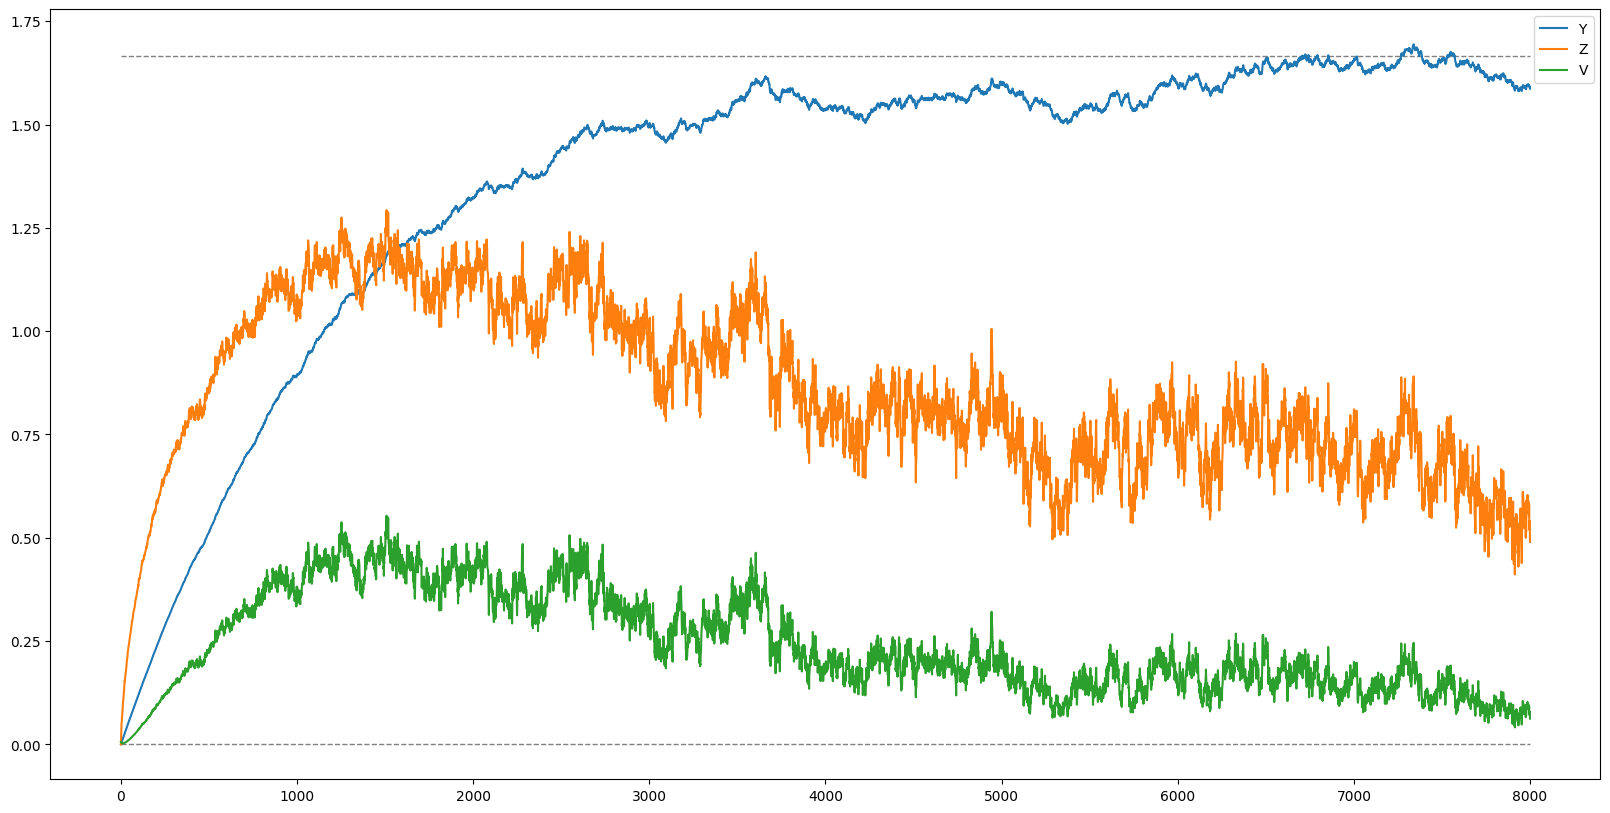

In [4]:
a = 0.384
b = 0.095
c = 0.0025
mu = 2
lam = 1.2
eta = 0.1
xi0 = 0
H = 0.1
N = 8000
M = 1
T = 5
Y, Z, V = simulate(xi0, H, mu, lam, a, b, c, eta, N, M, T)

fig = plt.figure(figsize=(20, 10))
x_start = 0
x_end = N
plt.hlines(y=mu/lam, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.hlines(y=0, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.plot(Y, label='Y')
plt.plot(Z, label='Z')
plt.plot(V, label='V')
plt.legend()
plt.show()

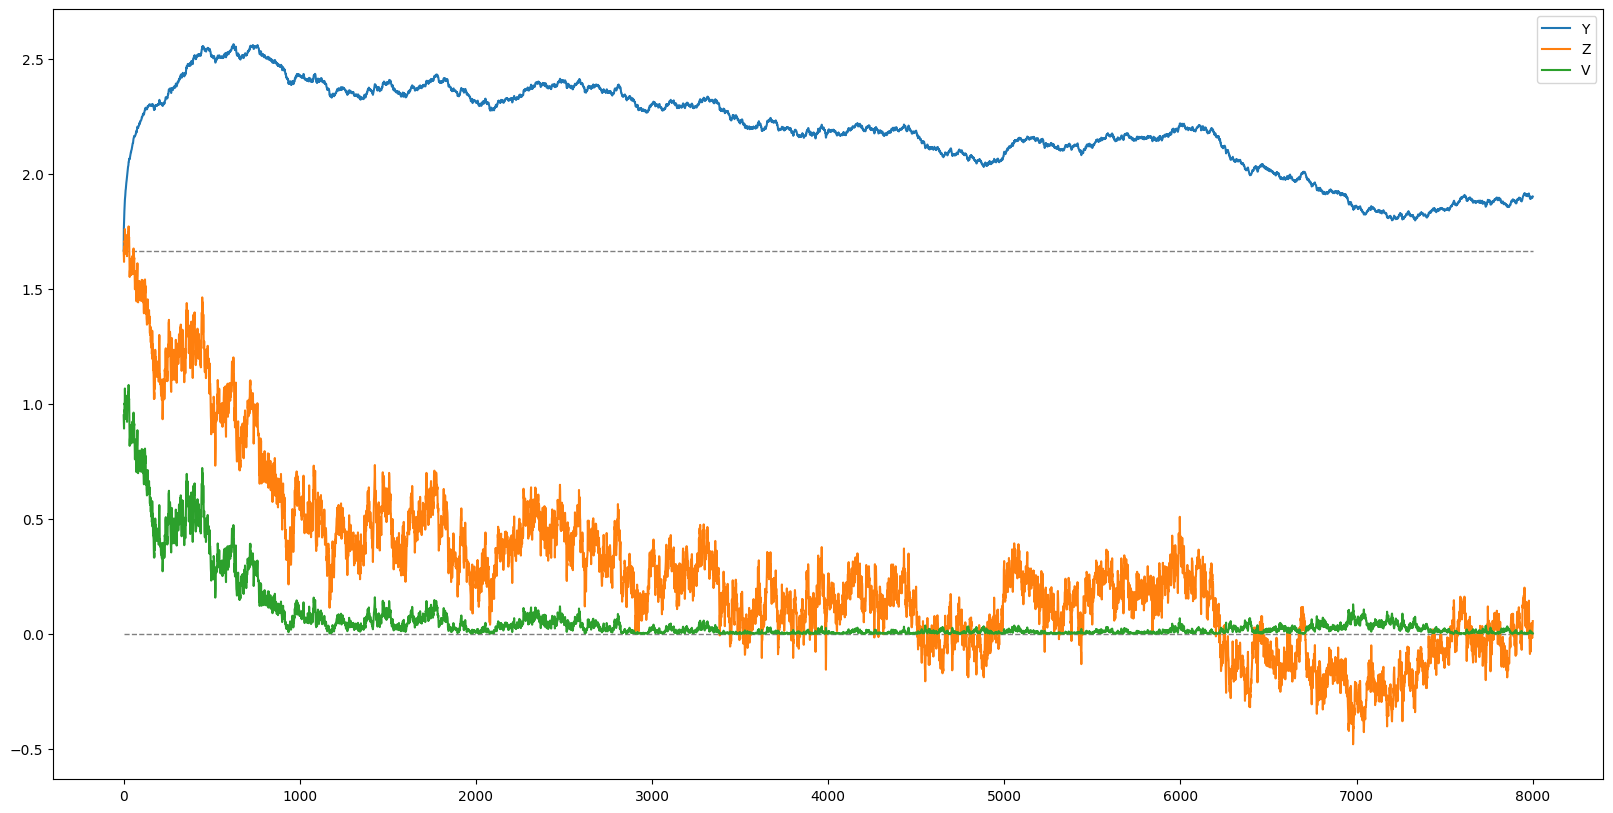

In [5]:
a = 0.384
b = 0.095
c = 0.0025
mu = 2
lam = 1.2
eta = 0.1
xi0 = mu/lam
H = 0.1
N = 8000
M = 1
T = 5
Y, Z, V = simulate(xi0, H, mu, lam, a, b, c, eta, N, M, T)

fig = plt.figure(figsize=(20, 10))
x_start = 0
x_end = N
plt.hlines(y=mu/lam, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.hlines(y=0, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.plot(Y, label='Y')
plt.plot(Z, label='Z')
plt.plot(V, label='V')
plt.legend()
plt.show()

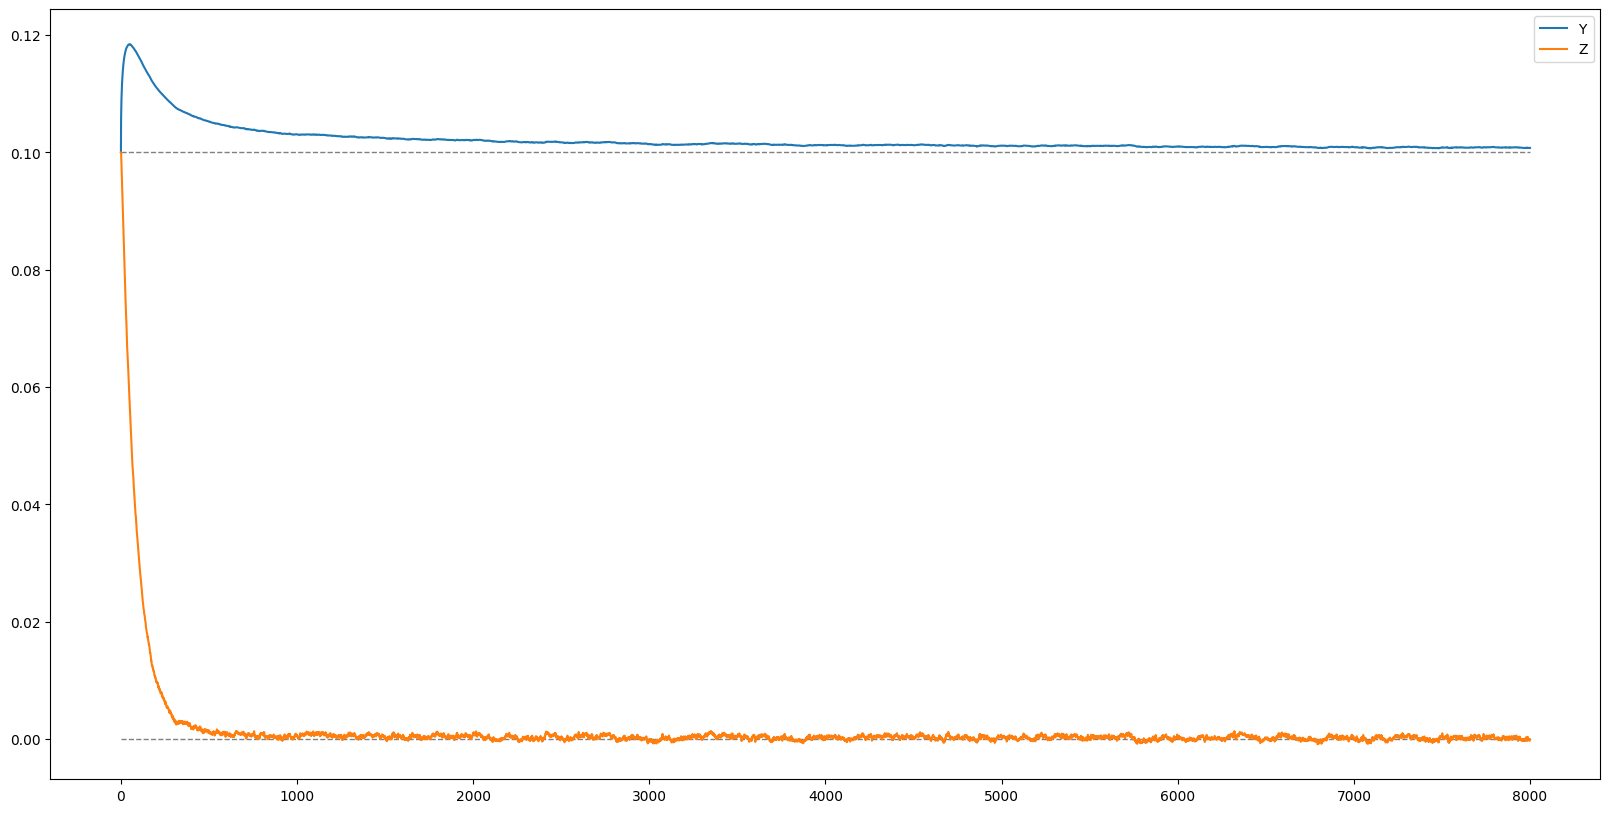

In [6]:
a = 0.384
b = 0.095
c = 0.0025
mu = 2
lam = 20
eta = 0.01
xi0 = mu/lam
H = 0.1
N = 8000
M = 1
T = 5
Y, Z, V = simulate(xi0, H, mu, lam, a, b, c, eta, N, M, T)

fig = plt.figure(figsize=(20, 10))
x_start = 0
x_end = N
plt.hlines(y=mu/lam, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.hlines(y=0, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.plot(Y, label='Y')
plt.plot(Z, label='Z')
plt.legend()
plt.show()

In [7]:
def matrix_C(n, l, alpha):
    C = np.zeros((n-l+1, n-l+1))
    for i in range(n-l+1):
        for j in range(i, n-l+1):
            f = lambda u: (((i+1) - u) * ((j+1) - u))**(alpha)
            integral, _ = quad(f, 0, 1)
            C[i][j] = integral
            C[j][i] = integral
    np.fill_diagonal(C, C.diagonal() + 0.00001) # for numerical stability

    return C

def generate_gaussian(n, alpha, C):

    G = (((T/n)**(2*alpha-1))/gamma(alpha)**2)*C
    L, D, _ = ldl(G)
    z = np.random.normal(0, 1, C.shape[0])
    Y = np.sqrt(D) @ z
    Z = L @ Y
    return Z

def simulate_ldl(xi0, H, mu, lam, a, b, c, eta, N, M, T):
    alpha = H+0.5
    C_total = []
    sample = []
    for l in range(1, N+1):
        C = matrix_C(N, l, alpha-1)
        C_total.append(C)
    for l in range(N):
        C = C_total[l]
        gaussian_vector = generate_gaussian(N, alpha, C)
        sample.append(gaussian_vector)

    h = T/N
    dW = np.sqrt(h) * rng.standard_normal((N, M))

    Y = np.zeros((N+1, M))
    Z = np.zeros((N+1, M))
    t = np.linspace(0, T, N+1)
    Y[0] = xi0
    Z[0] = xi0
    for n in range(1, N+1):
        delta_phi = phi(H, t[n])-phi(H, t[n-1])
        b_value = b_func(mu, lam, Y[n-1])
        sigma_value = sigma(a, b, c, Y[n-1])
        Y[n] = Y[n-1] + xi0*delta_phi + h*b_value + eta*sigma_value*dW[n-1]

        x = [sample[l-1][n-l] for l in range(1, n+1)]
        sum_vol = sum([eta*sigma(a, b, c, Y[l])*x[l] for l in range(n)])
        f = lambda s: (t[n]-s)**(alpha-1)
        integ = [quad(f, t[l], t[l+1])[0] for l in range(n)]
        sum_drift = sum([b_func(mu, lam, Y[l])*integ[l] for l in range(n)])/gamma(alpha)
        Z[n] = xi0 + sum_drift + sum_vol
    V = a*(Z-b)**2 + c
    return Y, Z, V

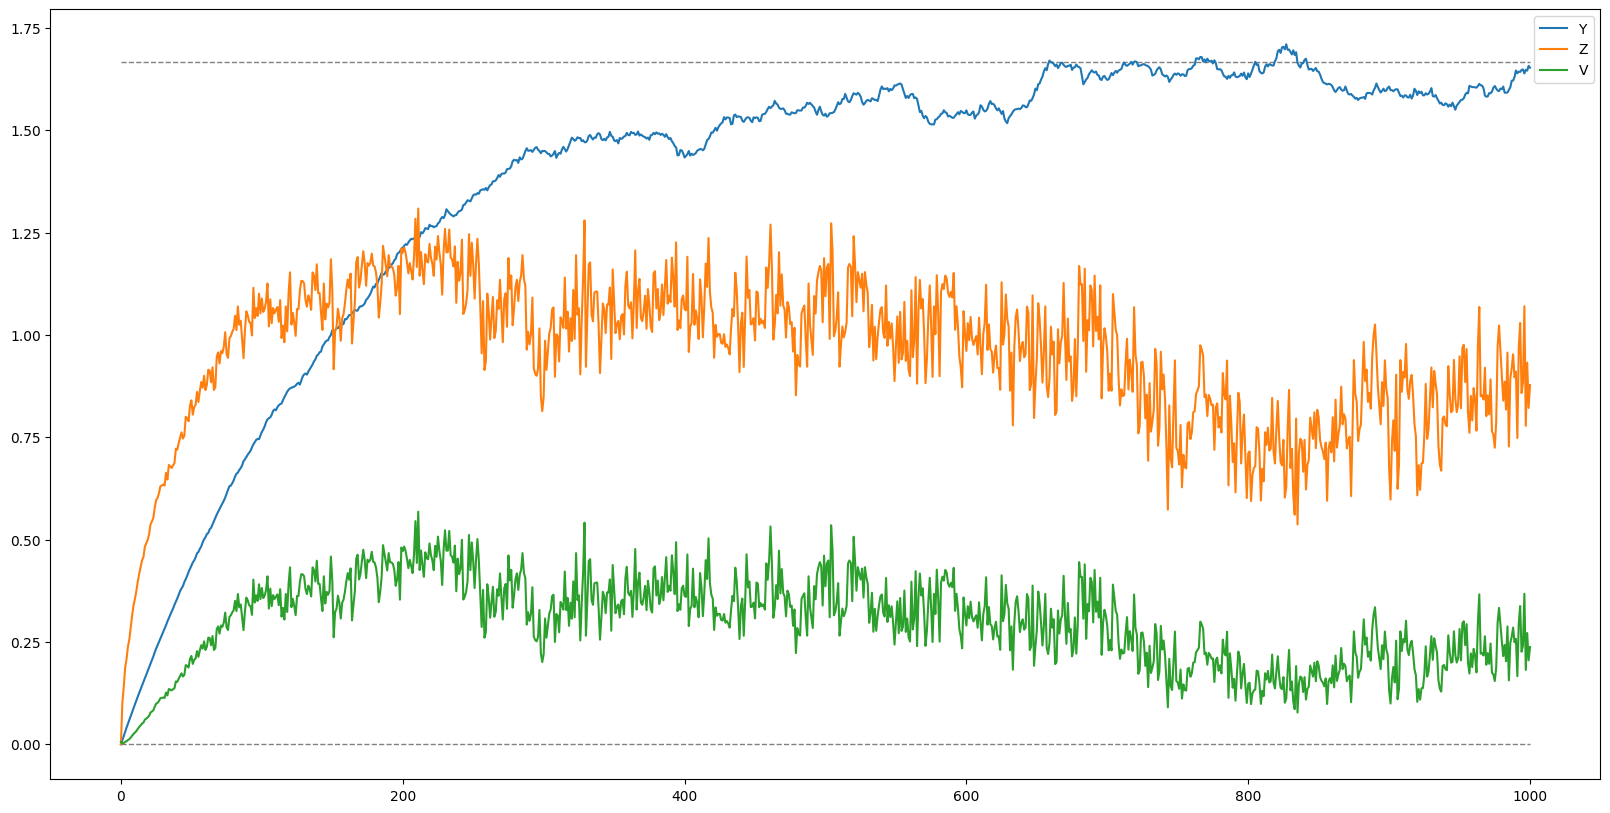

In [8]:
a = 0.384
b = 0.095
c = 0.0025
mu = 2
lam = 1.2
eta = 0.1
xi0 = 0
H = 0.1
N = 1000
M = 1
T = 5
Y, Z, V = simulate_ldl(xi0, H, mu, lam, a, b, c, eta, N, M, T)

fig = plt.figure(figsize=(20, 10))
x_start = 0
x_end = N
plt.hlines(y=mu/lam, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.hlines(y=0, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.plot(Y, label='Y')
plt.plot(Z, label='Z')
plt.plot(V, label='V')
plt.legend()
plt.show()

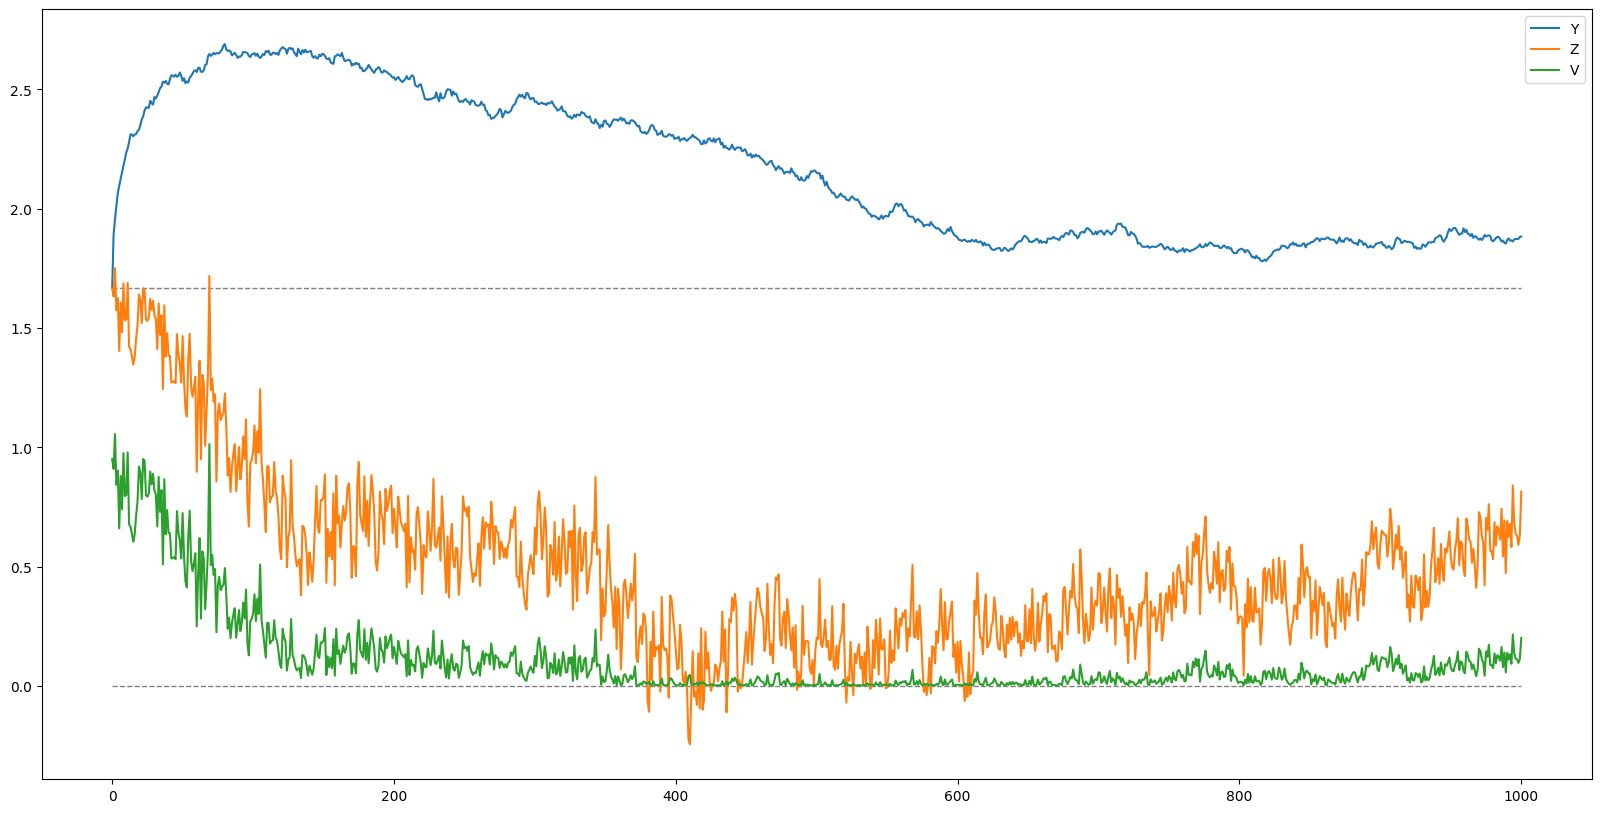

In [9]:
a = 0.384
b = 0.095
c = 0.0025
mu = 2
lam = 1.2
eta = 0.1
xi0 = mu/lam
H = 0.1
N = 1000
M = 1
T = 5
Y, Z, V = simulate_ldl(xi0, H, mu, lam, a, b, c, eta, N, M, T)

fig = plt.figure(figsize=(20, 10))
x_start = 0
x_end = N
plt.hlines(y=mu/lam, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.hlines(y=0, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.plot(Y, label='Y')
plt.plot(Z, label='Z')
plt.plot(V, label='V')
plt.legend()
plt.show()

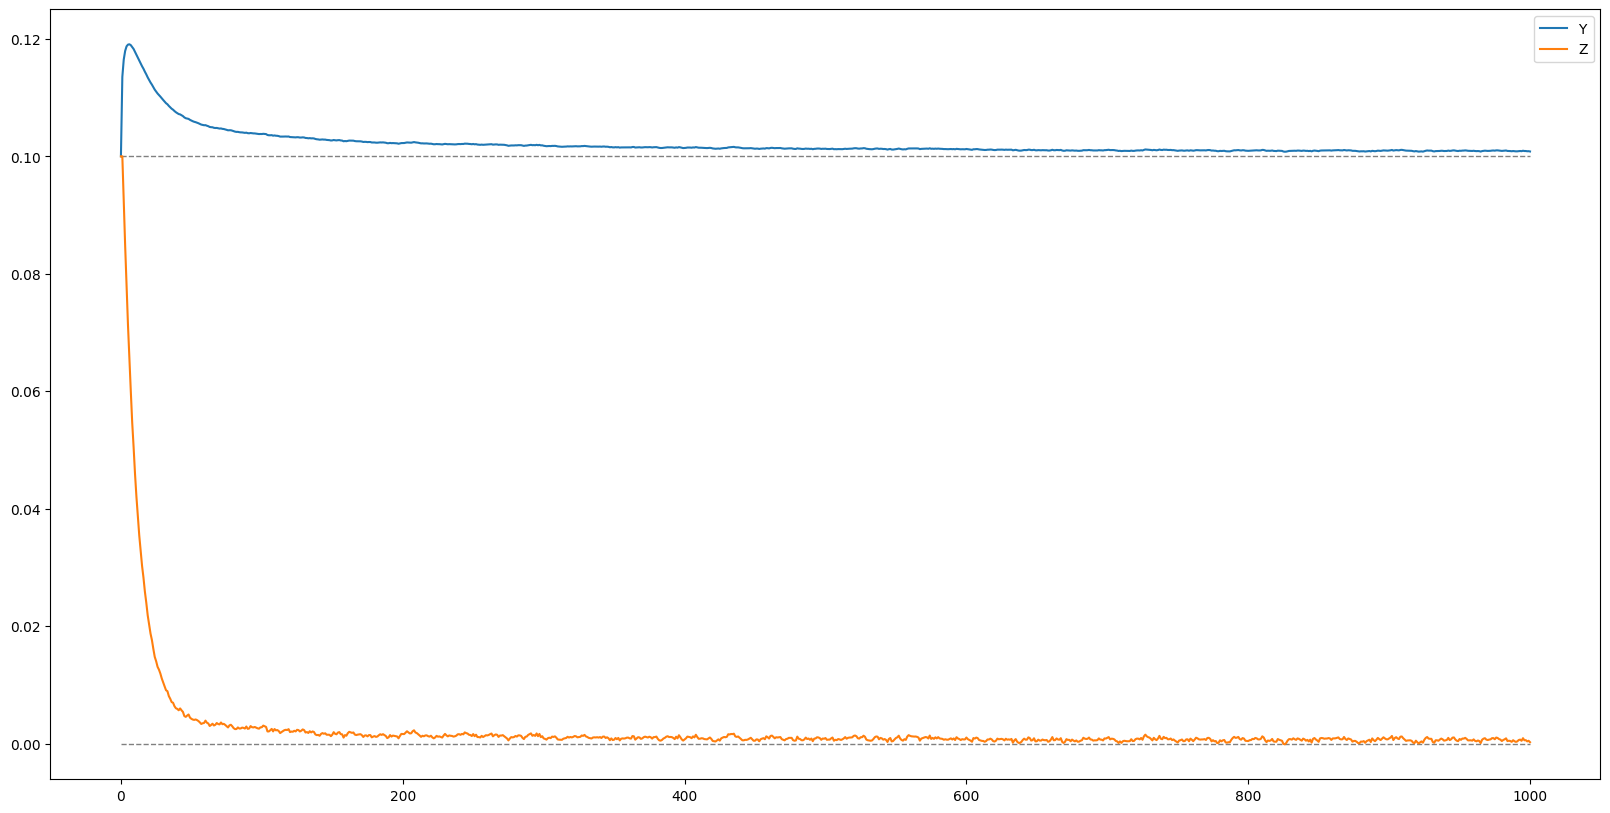

In [11]:
a = 0.384
b = 0.095
c = 0.0025
mu = 2
lam = 20
eta = 0.01
xi0 = mu/lam
H = 0.1
N = 1000
M = 1
T = 5
Y, Z, V = simulate_ldl(xi0, H, mu, lam, a, b, c, eta, N, M, T)

fig = plt.figure(figsize=(20, 10))
x_start = 0
x_end = N
plt.hlines(y=mu/lam, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.hlines(y=0, xmin=x_start, xmax=x_end,
            color='gray', linestyle='--', lw=1)
plt.plot(Y, label='Y')
plt.plot(Z, label='Z')
plt.legend()
plt.show()